In [1]:
import gym
import pandas as pd
import numpy as np

env = gym.make('CartPole-v1', render_mode='rgba_rray')

obs = env.reset()
obs

/Users/oscarpeace/Documents/CML/Practicals/03 - Wednesday/.venv/lib/python3.11/site-packages/gym/envs/registration.py:623: UserWarning: WARN: The environment is being initialised with mode (rgba_rray) that is not in the possible render_modes (['human', 'rgb_array']).
  logger.warn(


(array([-0.02481796, -0.03593536,  0.02552403, -0.02045062], dtype=float32),
 {})

In [2]:
def show_obs(the_obs):
    print(f"    Position  : {the_obs[0]}")
    print(f"    Speed     : {the_obs[1]}")
    print(f"    Angle     : {the_obs[2]}")
    print(f"    Rot Speed : {the_obs[3]}")

show_obs(obs[0])

    Position  : -0.02481795847415924
    Speed     : -0.03593536093831062
    Angle     : 0.025524025782942772
    Rot Speed : -0.020450619980692863


In [3]:
#env.render()

In [4]:
env.action_space

Discrete(2)

In [5]:
env.action_space.n

2

In [6]:
push_left = 0
push_right = 1

In [7]:
env.observation_space.low

array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32)

In [8]:
env.observation_space.high

array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)

In [9]:
action = push_right
obs, reward, done, info, _ = env.step(action)

/Users/oscarpeace/Documents/CML/Practicals/03 - Wednesday/.venv/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [10]:
show_obs(obs)

    Position  : -0.025536665692925453
    Speed     : 0.15881142020225525
    Angle     : 0.025115014985203743
    Rot Speed : -0.30497241020202637


In [11]:
reward

1.0

In [12]:
done

False

/Users/oscarpeace/Documents/CML/Practicals/03 - Wednesday/.venv/lib/python3.11/site-packages/gym/envs/classic_control/cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


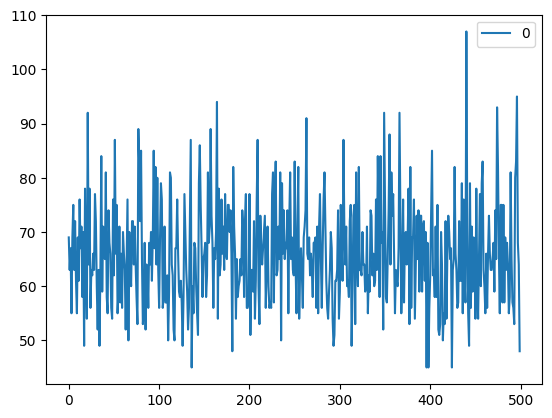

In [13]:
def simple_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    obs = env.reset()[0]
    episode_rewards = 0
    for step in range(200):
        action = simple_policy(obs)
        result = env.step(action)
        obs, reward, done, info, _ = result
        episode_rewards += reward
    
    totals.append(episode_rewards)

totals_chart = pd.DataFrame(totals)
ax = totals_chart.plot.line()

In [14]:
totals_chart.describe()

,0
count,500.000000
mean,65.980000
std,9.662626
min,45.000000
25%,59.000000
50%,65.000000
75%,72.000000
max,107.000000


In [15]:
import math
%matplotlib notebook
from matplotlib import pyplot as plt

env = gym.make('CartPole-v1')

buckets = (1, 1, 6, 12)
buckets

(1, 1, 6, 12)

In [16]:
Q = np.zeros(buckets + (env.action_space.n,))

In [17]:
n_episodes = 5
min_alpha = 0.1
min_epsilon = 0.1
gamma = 1.0
ada_divisor = 25
max_env_steps = None
monitor = False

In [18]:
def discretize(obs):
    upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]
    lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
    ratios = [(obs[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(obs))]
    new_obs = [int(round((buckets[i] - 1) * ratios[i])) for i in range(len(obs))]
    new_obs = [min(buckets[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
    return tuple(new_obs)

show_obs(obs)

    Position  : 7.325287342071533
    Speed     : -4.272242069244385
    Angle     : -7.052718639373779
    Rot Speed : -3.4034626483917236


In [19]:
discrete_obs = discretize(obs)
show_obs(discrete_obs)

    Position  : 0
    Speed     : 0
    Angle     : 0
    Rot Speed : 0


In [20]:
def choose_action(state, epsilon):
    return env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(Q[state])

def update_q(state_old, action, reward, state_new, alpha):
    Q[state_old][action] += alpha * (reward + gamma * np.max(Q[state_new]) - Q[state_old][action])

In [21]:
# Adaptive learning of Exploration Rate
def get_epsilon(t):
    return max(min_epsilon, min(1, 1.0 - math.log10((t + 1) / ada_divisor)))

# Adaptive learning of Learning Rate
def get_alpha(t):
    return max(min_alpha, min(1.0, 1.0 - math.log10((t + 1) / ada_divisor)))

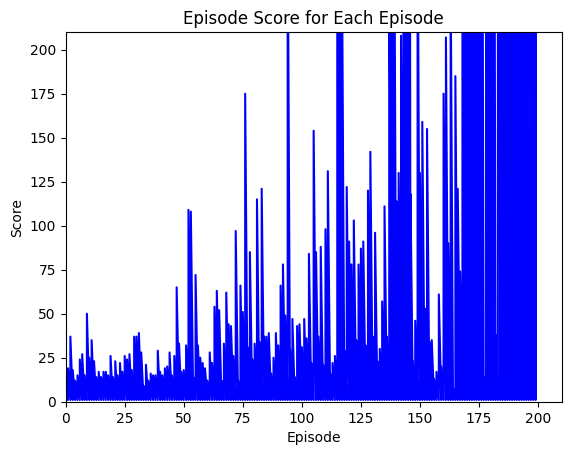

In [24]:
%matplotlib inline

n_episodes = 200 # (copy to make class demo faster! <200 )
y_chart = [] # Stores the y Axis data
x_chart = [] # Stores the score for each run (x values)
plt.figure(100) # Gives the plot a unique number (name)
plt.xlim((0,210)) # Max size of the x axis
plt.ylim((0,210)) # Max size of the y axis
plt.title('Episode Score for Each Episode') # Chart title
plt.ylabel('Score') # Label for the y axis
plt.xlabel('Episode') # Label for the x axis
for e in range(n_episodes): # Run many episodes (defined by n_episodes)
    # As states are continuous, discretize them into buckets
    current_state = discretize(env.reset()[0])
    # Get adaptive learning alpha and epsilon decayed over time
    alpha = get_alpha(e)
    epsilon = get_epsilon(e)
    done = False
    i = 0
    total_reward = 0
    while not done:
        # Render environment
        # env.render() # Comment out to make the code run faster
        # Choose action according to greedy policy and take it
        action = choose_action(current_state, epsilon)
        obs, reward, done, info, _ = env.step(action)
        new_state = discretize(obs)
        # Update Q-Table
        update_q(current_state, action, reward, new_state, alpha)
        current_state = new_state
        i += 1
        total_reward += reward
        y_chart.append(total_reward)
        x_chart.append(e)
        env.close()

plt.plot(x_chart,y_chart, color='blue')
plt.show()